***The content below is a solution to and a walk-through of the tutorial [Deep Learning for NLP with PyTorch](https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html).***

<h1>Sequence Models and LSTM Networks<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LSTM-in-PyTorch" data-toc-modified-id="LSTM-in-PyTorch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LSTM in PyTorch</a></span></li><li><span><a href="#An-LSTM-for-part-of-speech-tagging" data-toc-modified-id="An-LSTM-for-part-of-speech-tagging-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>An LSTM for part-of-speech tagging</a></span></li><li><span><a href="#Exercise:-LSTM-pos-tagger-with-character-level-features" data-toc-modified-id="Exercise:-LSTM-pos-tagger-with-character-level-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercise: LSTM pos tagger with character-level features</a></span></li></ul></div>

## LSTM in PyTorch

The semantics of the axes of these tensors is important.  (`NBW`)
* (number of sequences `N`) The first axis is the sequence itself, 
* (batch `B`) the second indexes instances in the mini-batch, and 
* (width `W`) the third indexes elements of the input.

*Note that the alphabetical codings are of my own - not conventional.*

If we want to run the sequence model over the sentence “The cow jumped”, our input should look like

$$
\begin{split}\begin{bmatrix}
\overbrace{q_\text{The}}^\text{row vector} \\
q_\text{cow} \\
q_\text{jumped}
\end{bmatrix}\end{split}
$$

Except remember there is an additional 2nd dimension with size 1.

**A quick example**:

Go through the sequence one at a time, in which case the 1st axis will have size 1 also.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(0);

In [3]:
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
inputs

[tensor([[ 1.5410, -0.2934, -2.1788]]),
 tensor([[ 0.5684, -1.0845, -1.3986]]),
 tensor([[ 0.4033,  0.8380, -0.7193]]),
 tensor([[-0.4033, -0.5966,  0.1820]]),
 tensor([[-0.8567,  1.1006, -1.0712]])]

In [4]:
# LSTM
lstm = nn.LSTM(3, 3)  # input dim: 3, output dim: 3

# Initialize the hidden state of LSTM
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))

In [5]:
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)  # 1 sequence, minibatch of 1 sample

In [6]:
out

tensor([[[-0.3595,  0.3648, -0.1099]]], grad_fn=<StackBackward>)

In [7]:
hidden
# first row: hidden state ($h_t$) 
# second row: cell state ($c_t$)

(tensor([[[-0.3595,  0.3648, -0.1099]]], grad_fn=<StackBackward>),
 tensor([[[-0.6077,  0.7131, -0.4391]]], grad_fn=<StackBackward>))

Alternatively, we can do the entire sequence all at once.

In [8]:
torch.cat(inputs)

tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193],
        [-0.4033, -0.5966,  0.1820],
        [-0.8567,  1.1006, -1.0712]])

In [9]:
# add the extra 2nd dim
inputs = torch.cat(inputs)
inputs = inputs.view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))

In [10]:
out, hidden = lstm(inputs, hidden)

In [11]:
out  # hidden states of all 5 LSTM cells (each corresponding to 5 inputs)

tensor([[[-0.1794,  0.0072,  0.2785]],

        [[-0.3096,  0.1303,  0.1442]],

        [[-0.3161,  0.2303, -0.0010]],

        [[-0.3107,  0.3189, -0.0664]],

        [[-0.3685,  0.3597, -0.1108]]], grad_fn=<StackBackward>)

In [12]:
hidden  # last hidden state & cell state

(tensor([[[-0.3685,  0.3597, -0.1108]]], grad_fn=<StackBackward>),
 tensor([[[-0.6269,  0.6967, -0.4441]]], grad_fn=<StackBackward>))

The first value returned by LSTM (`out`) is all of the hidden states throughout
the sequence. the second (`hidden`) is just the most recent hidden state
(compare the last slice of `out` with `hidden` below, they are the same)
The reason for this is that:
* `out` will give you access to all hidden states in the sequence
* `hidden` will allow you to continue the sequence and backpropagate,
by passing it as an argument to the lstm at a later time.

## An LSTM for part-of-speech tagging

preprocess the data

In [13]:
trainset = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

In [14]:
import numpy as np

In [15]:
vocab = np.r_[list(zip(*trainset))[0]]
vocab = list(map(lambda x: x.lower(), vocab))

In [16]:
word_to_ix = {word: idx for idx, word in enumerate(vocab)}
tag_to_ix = {"det": 0, "nn": 1, "v": 2}
# DET - determiner; NN - noun; V - verb

In [17]:
def prepare_(seq, to_ix):
    idxs = [to_ix[w.lower()] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

define model

In [18]:
VOCAB_SIZE = len(vocab)
TARGET_SIZE = len(tag_to_ix)
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

In [19]:
class LSTMTagger(nn.Module):
    def __init__(self):
        super(LSTMTagger, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM)  # input: embedding, output: hidden
        self.linear = nn.Linear(HIDDEN_DIM, TARGET_SIZE)
        
    def forward(self, x):
        len_seq = len(x)
        
        x = self.embedding(x)
        x = x.view(len_seq, 1, -1)
        
        x, _ = self.lstm(x)
        x = x.view(len_seq, -1)
        
        x = F.log_softmax(self.linear(x), dim=1)
        return x

train the model

In [20]:
model = LSTMTagger()

In [21]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [22]:
loss_history = []

for i in range(1, 501):
    loss_epoch = 0.
    for data, target in trainset:
        inputs = prepare_(data, to_ix=word_to_ix)
        targets = prepare_(target, to_ix=tag_to_ix)
        
        model.zero_grad()
        out = model(inputs)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
    loss_history.append(loss_epoch)

results

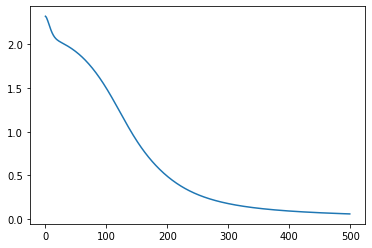

In [23]:
plt.plot(loss_history)

In [24]:
with torch.no_grad():
    for i in range(2):
        data = trainset[i][0]
        inputs = prepare_(data, word_to_ix)
        out = model(inputs)

        tags = torch.argmax(torch.exp(out), dim=1).numpy()

        print("sentence:", data)
        print("pos tags:", [{v: k.upper() for k, v in tag_to_ix.items()}[t] for t in tags])

sentence: ['The', 'dog', 'ate', 'the', 'apple']
pos tags: ['DET', 'NN', 'V', 'DET', 'NN']
sentence: ['Everybody', 'read', 'that', 'book']
pos tags: ['NN', 'V', 'DET', 'NN']


correctly tagged

## Exercise: LSTM pos tagger with character-level features

In the example above, each word had an embedding, which served as the inputs to our sequence model.

**Let’s augment the word embeddings with a representation derived from the characters of the word.** We expect that this should help significantly, since character-level information like affixes have a large bearing on part-of-speech. For example, words with the affix *-ly* are almost always tagged as adverbs in English.

To do this, let $c_w$
 be the character-level representation of word $w$
. Let $x_w$
 be the word embedding as before. Then the input to our sequence model is the concatenation of $x_w$
 and $c_w$
. So if $x_w$
 has dimension 5, and $c_w$
dimension 3, then our LSTM should accept an input of dimension 8.

To get the character level representation, do an LSTM over the characters of a word, and let $c_w$
 be the final hidden state of this LSTM.

In [25]:
chars = set("".join(vocab))
char_to_ix = {char.lower(): idx for idx, char in enumerate(chars)}

In [26]:
CHAR_SIZE = len(chars)
CHAR_EMBEDDING_DIM = 6
CHAR_HIDDEN_DIM = 3

In [27]:
class CharacterLevelEmbedder(nn.Module):
    def __init__(self):
        super(CharacterLevelEmbedder, self).__init__()
        
        self.char_embedding = nn.Embedding(CHAR_SIZE, CHAR_EMBEDDING_DIM)
        self.char_lstm = nn.LSTM(CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM)
        
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(CHAR_HIDDEN_DIM + EMBEDDING_DIM, HIDDEN_DIM)
        self.linear = nn.Linear(HIDDEN_DIM, TARGET_SIZE)
        
    def forward(self, sentence):
        len_seq = len(sentence)
        
        # x_w
        x = prepare_(sentence, word_to_ix)
        x = self.embedding(x)
        x = x.view(len_seq, 1, -1)
        
        # c_w
        cs = torch.zeros(len_seq, 1, CHAR_HIDDEN_DIM)
        for i, word in enumerate(sentence):
            c = prepare_(word, char_to_ix)
            c = self.char_embedding(c)
            c = c.view(len(word), 1, -1)
            
            c = self.char_lstm(c)
            cs[i, :, :] = c[1][0]  # the last hidden layer as c_w
        
        xc = torch.cat([x, cs], dim=2)
        xc, _ = self.lstm(xc)
        xc = xc.view(len_seq, -1)
        
        xc = F.log_softmax(self.linear(xc), dim=1)
        
        return xc

train the model

In [28]:
model = CharacterLevelEmbedder()

In [29]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [30]:
loss_history = []

for i in range(1, 501):
    loss_epoch = 0.
    for inputs, target in trainset:
        #inputs = prepare_(data, to_ix=word_to_ix)
        targets = prepare_(target, to_ix=tag_to_ix)
        
        model.zero_grad()
        out = model(inputs)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
    loss_history.append(loss_epoch)

results

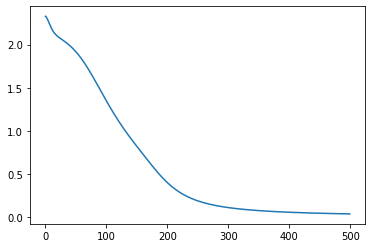

In [31]:
plt.plot(loss_history)

In [32]:
with torch.no_grad():
    for i in range(2):
        data = trainset[i][0]
        out = model(data)

        tags = torch.argmax(torch.exp(out), dim=1).numpy()

        print("sentence:", data)
        print("pos tags:", [{v: k.upper() for k, v in tag_to_ix.items()}[t] for t in tags])

sentence: ['The', 'dog', 'ate', 'the', 'apple']
pos tags: ['DET', 'NN', 'V', 'DET', 'NN']
sentence: ['Everybody', 'read', 'that', 'book']
pos tags: ['NN', 'V', 'DET', 'NN']


correctly tagged